In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import random
import scipy
from distcorr import distcorr
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

In [53]:
x = np.array([400, 405, 410, 415, 420, 425, 430, 435, 436, 438, 439, 441, 442, 444, 445, 447, 448, 450, 451, 453, 454, 456, 457, 459, 460, 462, 463, 465, 470, 475, 480, 485, 490, 495, 500])

y = np.array([0.0001575, 0.0001699, 0.0002350, 0.0003102, 0.0004917, 0.0008710, 0.0017418, 0.0046400, 0.0065895, 0.0097302, 0.0149002, 0.0237310, 0.0401683, 0.0712559, 0.1264458, 0.2073413, 0.2902366, 0.3445623, 0.3698049, 0.3668534, 0.3106727, 0.2078154, 0.1164354, 0.0616764, 0.0337200, 0.0194023, 0.0117831, 0.0074357, 0.0022732,0.0008800, 0.0004579, 0.0002345, 0.0001586, 0.0001143, 0.0000710])

In [54]:
corr, _ = pearsonr(x, y)
print(corr)

0.03283050839380204


In [55]:
dist_corr = scipy.spatial.distance.correlation(x, y)
print(dist_corr)

0.967169491606198


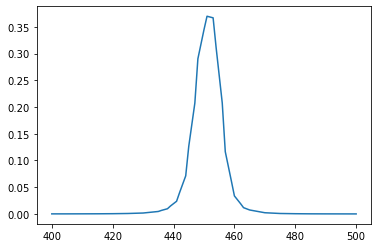

In [56]:
plt.plot(x, y)

In [57]:
x_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

x_scaled = (x_scaler.fit_transform(x.reshape(-1,1)))
y_scaled = (y_scaler.fit_transform(y.reshape(-1,1)))

In [58]:
corr, _ = pearsonr(x_scaled.reshape(35), y_scaled.reshape(35))
print(corr)

0.03283050839380205


In [59]:
average_value = np.mean(y_scaled)
average_value

0.20484863766694295

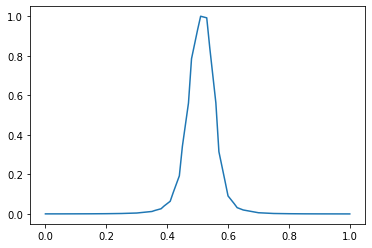

In [60]:
plt.plot(x_scaled, y_scaled)

In [61]:
bins = np.linspace(0, 0.4, 5)

y_binned = np.digitize(y_scaled, bins)

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, stratify=y_binned, random_state=0)

In [63]:
x_train = torch.from_numpy(x_train)
x_train = x_train.view(1, x_train.shape[0], 1)

x_test = torch.from_numpy(x_test)
x_test = x_test.view(1, x_test.shape[0], 1)

y_train = torch.from_numpy(y_train)
y_train = y_train.view(1, y_train.shape[0], 1)

y_test = torch.from_numpy(y_test)
y_test = y_test.view(1, y_test.shape[0], 1)

x_train.shape

torch.Size([1, 26, 1])

In [64]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=1, out_features=2)
        self.enc2 = nn.Linear(in_features=2, out_features=4)
        self.enc3 = nn.Linear(in_features=4, out_features=8)

        self.dec00 = nn.Linear(in_features=8, out_features=4)
        self.dec0 = nn.Linear(in_features=4, out_features=2)
        self.dec1 = nn.Linear(in_features=2, out_features=1)

    
    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = F.leaky_relu(self.enc3(x))
        x = F.leaky_relu(self.dec00(x))
        x = F.leaky_relu(self.dec0(x))
        x = self.dec1(x)
        return x


In [65]:
random.seed(2)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()
print(net)

Autoencoder(
  (enc1): Linear(in_features=1, out_features=2, bias=True)
  (enc2): Linear(in_features=2, out_features=4, bias=True)
  (enc3): Linear(in_features=4, out_features=8, bias=True)
  (dec00): Linear(in_features=8, out_features=4, bias=True)
  (dec0): Linear(in_features=4, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=1, bias=True)
)


In [43]:
NUM_EPOCHS = 1000
LEARNING_RATE = 0.01

In [44]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [45]:
def train(net):
    train_loss = []
    torch.set_printoptions(precision=3, sci_mode=False)
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for missing_data, full_data in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(missing_data.double())
            loss = criterion(outputs, full_data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if epoch == NUM_EPOCHS-1:
                for i in range(len(missing_data)):
                    print("Input: ", missing_data[i])
                    print("Target: ", full_data[i])
                    print("Outputs: ", outputs[i])

        loss = running_loss / len(x_train)
        train_loss.append(loss)

        print('Epoch {} of {}, Train Loss: {:.5f}'
            .format(epoch+1, NUM_EPOCHS, loss))

    return train_loss


def test(net):

    net.eval()

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0

        for missing_data, full_data in zip(x_test, y_test):
            outputs = net(missing_data.double())
            loss = criterion(outputs, full_data)
            running_loss += loss.item()
            for i in range(len(missing_data)):
                    print("Input: ", missing_data[i])
                    print("Target: ", full_data[i])
                    print("Outputs: ", outputs[i])

        loss = running_loss / len(x_test)
        test_loss.append(loss)
        print('Test Loss: {:.5f}'.format(loss))

        return test_loss

In [58]:
train_loss1 = train(net)


ain Loss: 0.00030
Epoch 598 of 1000, Train Loss: 0.00030
Epoch 599 of 1000, Train Loss: 0.00030
Epoch 600 of 1000, Train Loss: 0.00030
Epoch 601 of 1000, Train Loss: 0.00029
Epoch 602 of 1000, Train Loss: 0.00030
Epoch 603 of 1000, Train Loss: 0.00030
Epoch 604 of 1000, Train Loss: 0.00030
Epoch 605 of 1000, Train Loss: 0.00031
Epoch 606 of 1000, Train Loss: 0.00032
Epoch 607 of 1000, Train Loss: 0.00033
Epoch 608 of 1000, Train Loss: 0.00033
Epoch 609 of 1000, Train Loss: 0.00034
Epoch 610 of 1000, Train Loss: 0.00034
Epoch 611 of 1000, Train Loss: 0.00035
Epoch 612 of 1000, Train Loss: 0.00034
Epoch 613 of 1000, Train Loss: 0.00034
Epoch 614 of 1000, Train Loss: 0.00033
Epoch 615 of 1000, Train Loss: 0.00032
Epoch 616 of 1000, Train Loss: 0.00032
Epoch 617 of 1000, Train Loss: 0.00031
Epoch 618 of 1000, Train Loss: 0.00031
Epoch 619 of 1000, Train Loss: 0.00030
Epoch 620 of 1000, Train Loss: 0.00031
Epoch 621 of 1000, Train Loss: 0.00030
Epoch 622 of 1000, Train Loss: 0.00030
Epoch 6

Text(0, 0.5, 'Loss')

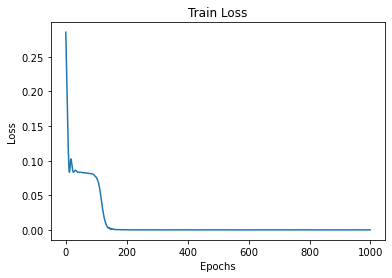

In [59]:
plt.figure()
plt.plot(train_loss1)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [61]:
test_result = test(net)

Input:  tensor([0.150], dtype=torch.float64)
Target:  tensor([0.001], dtype=torch.float64)
Outputs:  tensor([0.004], dtype=torch.float64)
Input:  tensor([0.], dtype=torch.float64)
Target:  tensor([0.000], dtype=torch.float64)
Outputs:  tensor([-0.008], dtype=torch.float64)
Input:  tensor([0.440], dtype=torch.float64)
Target:  tensor([0.193], dtype=torch.float64)
Outputs:  tensor([0.208], dtype=torch.float64)
Input:  tensor([0.850], dtype=torch.float64)
Target:  tensor([0.000], dtype=torch.float64)
Outputs:  tensor([0.003], dtype=torch.float64)
Input:  tensor([0.530], dtype=torch.float64)
Target:  tensor([0.992], dtype=torch.float64)
Outputs:  tensor([0.953], dtype=torch.float64)
Input:  tensor([0.350], dtype=torch.float64)
Target:  tensor([0.012], dtype=torch.float64)
Outputs:  tensor([0.024], dtype=torch.float64)
Input:  tensor([0.510], dtype=torch.float64)
Target:  tensor([1.000], dtype=torch.float64)
Outputs:  tensor([0.979], dtype=torch.float64)
Input:  tensor([0.600], dtype=torch.

In [24]:
torch.save(net, './model2')

In [66]:
load_model = torch.load('model2')
load_model

Autoencoder(
  (enc1): Linear(in_features=1, out_features=2, bias=True)
  (enc2): Linear(in_features=2, out_features=4, bias=True)
  (enc3): Linear(in_features=4, out_features=8, bias=True)
  (dec00): Linear(in_features=8, out_features=4, bias=True)
  (dec0): Linear(in_features=4, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=1, bias=True)
)

In [77]:
predicted = load_model(torch.Tensor(x_scaled).double())

In [81]:
predicted_value = predicted.reshape(-1, 1).detach().numpy()
expected_value = y_scaled.reshape(-1, 1)
comparison_column = x_scaled.reshape(-1, 1)


In [82]:
print(distcorr(comparison_column.flatten(), expected_value.flatten()))
print(distcorr(comparison_column.flatten(), predicted_value.flatten()))

0.4275028979381044
0.4293861027080221


In [83]:
from scipy import stats
from statsmodels.stats import weightstats as stets

ttest, pval = stats.ttest_ind(predicted_value, expected_value)
print("P-value for significance: ", pval)
print("TTEST: ", ttest)

if pval<0.05:
    print("Conclusion: Reject Null Hypothesis")
else:
    print("Conclusion: Accept Null Hypothesis")

P-value for significance:  [0.95408988]
TTEST:  [0.05778435]
Conclusion: Accept Null Hypothesis


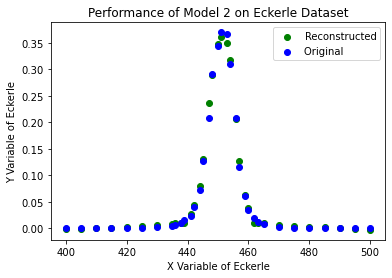

In [85]:
# Plot in blue color the predicted adata and in green color the
# actual data to verify visually the accuracy of the model.
plt.scatter(x_scaler.inverse_transform(comparison_column), y_scaler.inverse_transform(predicted_value), color="green", label='Reconstructed')
plt.scatter(x_scaler.inverse_transform(comparison_column), y_scaler.inverse_transform(expected_value), color="blue", label='Original ')
plt.xlabel('X Variable of Eckerle')
plt.ylabel('Y Variable of Eckerle')
plt.title('Performance of Model 2 on Eckerle Dataset')
plt.legend()
plt.show()